In [16]:
import pandas as pd

df = pd.read_csv('../data/1. raw/1. data_omicron_indo.csv', delimiter="\t")
df.head(1)

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1479629342183358465,1479629342183358465,2022-01-08 08:41:40 SE Asia Standard Time,2022-01-08,08:41:40,700,371272327,yagdrasiil,Imam Nur Hidayat,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [17]:
data_text = pd.DataFrame(df['tweet'])

In [18]:
data_text.head(10)

,tweet
0,"Sibuk liburan luar negeri, pulang2 bawa omicro..."
1,"Cegah Omicron, Wapres : tidak boleh ada diapen..."
2,"@CNNIndonesia Gk tau omicron, gua tau nya unicorn"
3,"@cybsquad_ itukan tugas mereka, hampir semua a..."
4,"kalo gini mana bisa kuliah offline, orang omic..."
5,Putik Omicron
6,Orang kayak jalan2 ke turki pulang bawa omicro...
7,Populer Sains: super immunity diduga sudah ter...
8,"Eh, dengar-dengar ada segerombolan keluarga be..."
9,OMICRON tuh ada kat Makkah je ke? Sbb mcm baca...


In [19]:
data_text["tweet"].duplicated().sum(), len(data_text["tweet"])

(52, 10013)

In [20]:
data_text["tweet"] = data_text[~data_text.tweet.str.contains("Omicron is a Global Calamity")]

data_text = data_text.drop_duplicates(subset=['tweet'], keep=False)
data_text["tweet"].duplicated().sum(), len(data_text["tweet"])


(0, 9731)

In [21]:
data_text["label"] = ""
data_text.head(3)

,tweet,label
0,"Sibuk liburan luar negeri, pulang2 bawa omicro...",
1,"Cegah Omicron, Wapres : tidak boleh ada diapen...",
2,"@CNNIndonesia Gk tau omicron, gua tau nya unicorn",


In [22]:
# Cleaning
from nltk import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from string import punctuation
import re

def text_cleaning(data):
    # case folding
    data = data.lower()
    # remove punctuation
    data = re.sub('[^\w\s]', ' ', data)
    # remove numbers
    data = re.sub('\d+', '', data)
    # remove extra whitespace
    data = ' '.join(data.split())
    # remove emoji
    data = re.sub(r'[^\x00-\x7F]+', ' ', data)
    # remove new line
    data = re.sub('\n', ' ', data)

    return data

# Stemming

def stemmer_sastrawi(data):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    data = stemmer.stem(data)

    return data


# Stopword Removal


def stopword_removal(data):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    data = stopword.remove(data)

    return data


# Bahasa alay removal
# Kamus alay
kamus_alay_1 = pd.read_csv(
    "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt",
    delimiter="\t",
    header=None,
    names=['slang', 'formal'])
kamus_alay_2 = pd.read_csv(
    "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv",
    usecols=["slang", "formal"])

kamus_alay = pd.concat([kamus_alay_1, kamus_alay_2])

# Dictionary bahasa alay
dict_alay = dict()
for index, row in kamus_alay.iterrows():
    dict_alay[row['slang']] = row['formal']


def normalize_text(data):
    word_tokens = word_tokenize(data)
    result = [dict_alay.get(w, w) for w in word_tokens]
    return ' '.join(result)


def preprocessing(data):
    data = text_cleaning(data)
    data = normalize_text(data)
    data = stemmer_sastrawi(data)
    data = stopword_removal(data)
    return data

In [23]:
from tqdm.auto import tqdm
import preprocessor as p
tqdm.pandas()
tes_filter = data_text["tweet"].progress_apply(p.clean)
tes_filter[:10]

100%|██████████| 9731/9731 [00:00<00:00, 14830.38it/s]


0    Sibuk liburan luar negeri, pulang2 bawa omicro...
1    Cegah Omicron, Wapres : tidak boleh ada diapen...
2                  Gk tau omicron, gua tau nya unicorn
3    itukan tugas mereka, hampir semua artis itukan...
4    kalo gini mana bisa kuliah offline, orang omic...
5                                        Putik Omicron
6    Orang kayak jalan2 ke turki pulang bawa omicro...
7    Populer Sains: super immunity diduga sudah ter...
8    Eh, dengar-dengar ada segerombolan keluarga be...
9    OMICRON tuh ada kat Makkah je ke? Sbb mcm baca...
Name: tweet, dtype: object

In [24]:
tes_filter = tes_filter.progress_apply(preprocessing)
tes_filter[:10]

100%|██████████| 9731/9731 [00:51<00:00, 188.23it/s]


0    sibuk libur negeri pulang bawa omicron ppkm in...
1            cegah omicron wapres diapensasi karantina
2                                      omicron unicorn
3    tugas artis influencer rezim jokowi varian del...
4                 kuliah offline omicron deh indonesia
5                                        putik omicron
6    kayak jalan turki pulang bawa omicron dampak p...
7    populer sains super immunity duga bentuk hewan...
8    eh dengar dengar gerombol keluarga ngartis syo...
9    omicron kat makkah je baca asyik jemaah umrah ...
Name: tweet, dtype: object

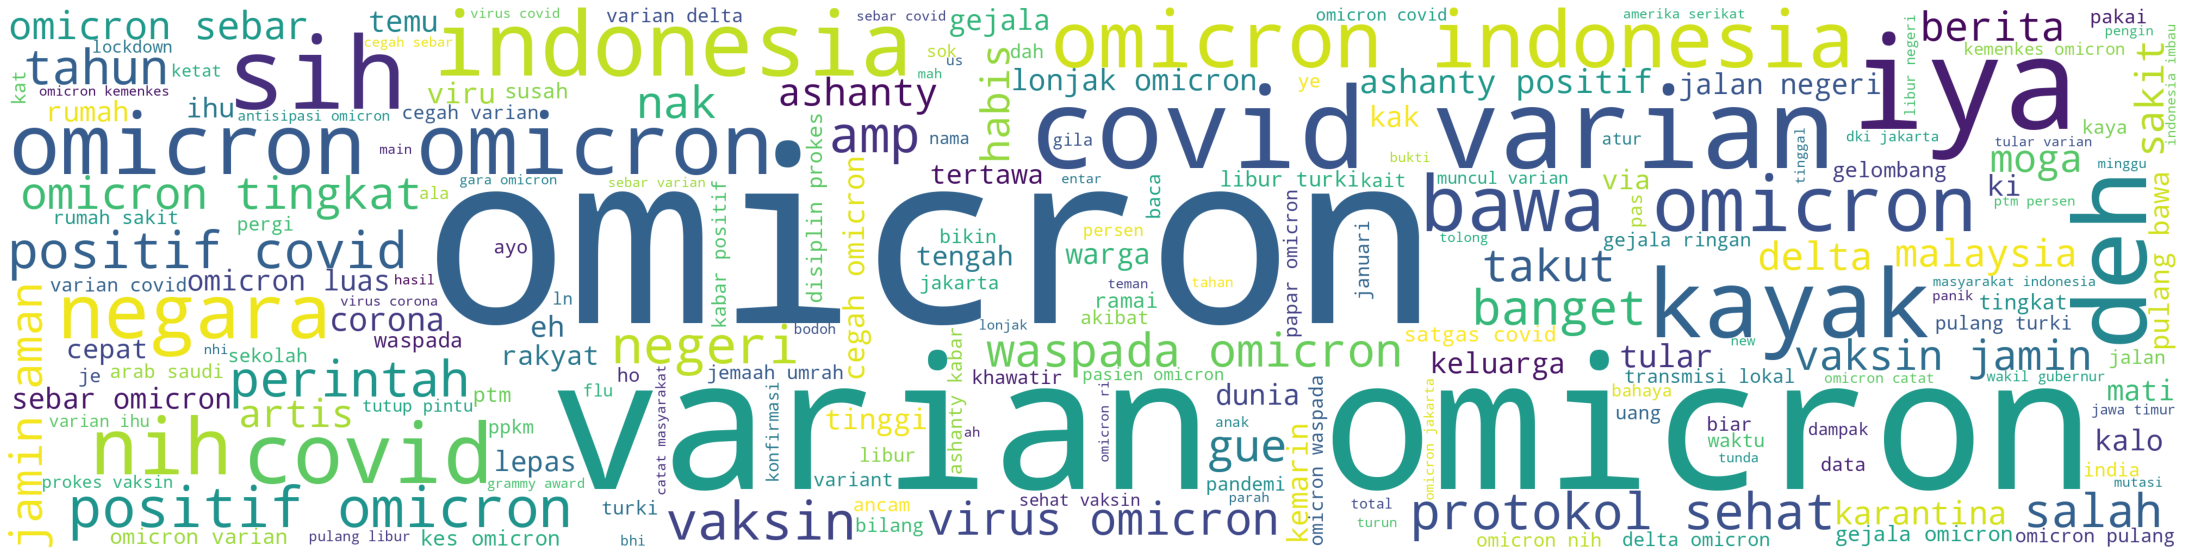

In [25]:
# wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_data = ' '.join(tes_filter)
wordcloud = WordCloud(background_color='white', width=4000,
                      height=1000).generate(all_data)
plt.figure(figsize=(40, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [27]:
data_text.to_csv("tweet_omicron_filtered_1.csv", index=False)